## Summary of product characteristics (SmPC)

A document describing the properties and the officially approved conditions of use of a medicine. Summaries of product characteristics form the basis of information for healthcare professionals on how to use the medicine safely and effectively. Abbreviated as SmPC. 
<br/>

### Structure of an SmPC
The structure of the SmPC is defined by the European pharmaceutical legislation. The information included in the SmPC should be product specific and can be cross-referenced to avoid any redundancy. It should be documented in a clear language and should not lead to any ambiguity. The SmPC is divided into 6 major sections:

1. Name of the product
2. Composition
3. Pharmaceutical Form
4. Clinical particulars – Includes therapeutic indications, recommendation for dosages and safety information
5. Pharmacological properties – Takes into account the therapeutic indications of the clinical elements and their potential adverse drug reactions
6. Pharmaceutical particulars – Includes Regulatory information related to the drug

<br/>

<img src="./images/structureSmPC.png" width="600px;">

<br/>
<br/>

### Extract Tabulated Summary of Adverse Reactions from the 4.8 section 

This section should include all adverse reactions for which, after thorough assessment, a causal relationship between the medicinal product and the adverse event is at least a reasonable possibility. These ADRs should be all reactions from:
* Clinical trials
* Post-authorisation safety studies
* Spontaneous reporting

#####  The tabulated list of adverse reactions in section 4.8:
* Introduce table with short paragraph stating source of safety database
* Separate tables are acceptable in exceptional cases where adverse profiles markedly differ depending on the use of the product.

#####  Structure of the table: general considerations

* Table should be written according to MedDRA system organ classification (SOC)
* A pragmatic approach to the location of terms should be taken in order to make the identification of adverse reactions simpler and clinically appropriate for the reader
* Within each SOC, adverse reactions should be ranked under headings of frequency, most frequent reactions first
* Frequency grouping, adverse reactions should be presented in order of decreasing seriousness

##### Frequency Grouping:
* Very common (≥1/10)
* Common (≥1/100 to <1/10)
* Uncommon (≥1/1,000 to <1/100)
* Rare (≥1/10,000 to <1/1,000)
* Very rare (<1/10,000)
* Frequency not known (cannot be estimated from the available data)

#### SmPCs Examples

<img src="./images/SmPCs_example.png" width="500px;">


## MedDRA
MedDRA is a multilingual terminology allowing most users to operate in their native languages. The table below identifies the initial MedDRA version when each MedDRA language was made available to users. 

<br />

<img src="./images/MedDRA_Hierarchy.png" width="500px;">

<br />

The most important reason to “code” data into a standardised terminology is to analyse it. A key benefit of MedDRA is in its support of straightforward as well as sophisticated analyses. MedDRA can be used to analyse individual medical events (e.g., “Influenza”) or issues involving a system, organ or aetiology (e.g., infections) using its hierarchical structure. MedDRA can be used for signal detection and monitoring of clinical syndromes whose symptoms encompass numerous systems or organs using its multiaxial hierarchy or through the special feature of Standardised MedDRA Queries.

<br />

### MedDRA Hierarchy

The structure of MedDRA is very logical. There are five levels to the MedDRA hierarchy, arranged from very specific to very general. Download [MedDRA codes](https://www.ema.europa.eu/en/documents/other/meddra-important-medical-event-terms-list-version-261_en.xlsx) and extract the unique values from the SOC Name column

### Project Overview

Using natural language processing (NLP) techniquesto automatically extract adverse drug reactions from such unstructured textual information helps clinicalexperts to effectively and efficiently use them in daily practices. Such techniques have been developed for Structured Product Labels from the Food and Drug Administration (FDA), but there is no researchfocusing on extracting from the Summary of Product Characteristics.


In this work, we built a naturallanguage processing pipeline that automatically scrapes the summary of product characteristics online and then extracts adverse drug reactions from them.

<img src="./images/Project_Overview.png" width="600px;">

In [27]:
import os
import re
from bs4 import BeautifulSoup
import pandas as pd
import requests

PATH = "./data"

In [28]:
medra = pd.read_excel(os.path.join(PATH, "MedDRA", "meddra-important-medical-event-terms-list-version-261_en.xlsx"))

In [370]:
# SOC Regular Expression
socList = [".*" + term.replace(",", "").replace(" ", ".*") + ".*" for term in medra['SOC Name'].unique()]
SOCListRegex = '(?i)(?:% s)' % '|'.join(socList)
regexSOC = re.compile(SOCListRegex)

# Match phrases where the first word starts with an uppercase letter followed by lowercase letters
regexUpperCase = re.compile(r'\b[A-Z][a-z]*(?:\s+–\s+[A-Za-z]+)*')

# Search for pattern:  <p> frequency: ad, ad, ... </p>
regexPtag = re.compile(r"<p><i>(.*):</i>\s*(.*)</p>")

# Search for pattern: frequency: adverse_reaction_1, adverse_reaction_2, ...
regexFreqAr = re.compile(r"(?i)(Very common|Common|Uncommon|Rare|Very rare|Frequency not known|Not known):\s*([^<]*(?:<br>[^<]*)*)")

# Search for frequencies
regexFreq = re.compile("(?i)(Very common|Common|Uncommon|Rare|Very rare|Frequency not known|Not known)")

# Extract drug
regexDrug = r'/monographs/([^/]+)'

# Remove tags
regexRemoveParenthesis = r'[^<(\n]+'

In [415]:
urls = [
    # p tags
    # 'https://www.rxreasoner.com/monographs/abseamed/precautions',
    # 'https://www.rxreasoner.com/monographs/abilify-inj-sol/precautions',
    # 'https://www.rxreasoner.com/monographs/abstral/precautions',
    # 'https://www.rxreasoner.com/monographs/acomplia/precautions',
    # 'https://www.rxreasoner.com/monographs/ajovy/precautions',
    
    # table tags
    # 3 columns space seperated
    # 'https://www.rxreasoner.com/monographs/abecma/precautions',
    'https://www.rxreasoner.com/monographs/agamree/precautions',
    'https://www.rxreasoner.com/monographs/ebixa-tab/precautions',
    
    # 2 columns
    #'https://www.rxreasoner.com/substances/abiraterone/precautions'

    # 1 column
    # 'https://www.rxreasoner.com/monographs/adasuve/precautions'
]

In [416]:
def get_indexes(columns):
    print("Columns: ", columns)
    if 'frequency' in columns[1].lower():
       return 1, 2
    else:
        return 2, 1

In [417]:
for url in urls:

    # Extract drug name
    match = re.search(regexDrug, url)
    drug = match.group(1)
    
    print(f"Download precautions of drug {drug} from: {url}") 

    # List of frequencies and adverse reactions
    frequencies = []
    adverse_reactions = []

    # Fetch the HTML content
    html_content = requests.get(url).text

    # Parse the HTML content
    soup = BeautifulSoup(html_content, "html.parser")

    # Find p tags
    ptags = soup.find_all("p")
    
    if ptags:
        print("It has p tags")
        for p in ptags:
            match = regexPtag.search(str(p))
            
            if match:
                frequency = match.group(1)
                adverse_reaction = re.sub(r'<[^>]*>|\(.*?\)', '', match.group(2))
                for ar in adverse_reaction.split(','):                    
                    frequencies.append(frequency)
                    adverse_reactions.append(ar.strip())

        pd.DataFrame({'ADR': adverse_reactions, 'FREQ': frequencies}).to_csv(os.path.join(PATH, "extracted_tables", drug + ".csv"), sep=';', encoding='utf-8', index=False,  mode='a', header=False)

    
    # Find table tags
    tables = soup.find_all("table")

    if tables:
        print("It has p tables")
        for i, table in enumerate(tables):
            
            # The Pandas read_html function converts HTML table into DataFrame
            df = pd.read_html(str(table))[0]
        
            # If table contains SOC in the first column
            if df.iloc[:, 0].str.contains(regexSOC, regex=True).any():
                header_frequncies = None
                frequencies = []
                adverse_reactions = []
                print(f"Table {i} contains SOC")
        
                
                # Check if any column name matches the regex pattern
                matches = [col for col in df.columns if regexFREQ.match(col)]
        
                if matches:
                   print("Frequencies in header: ", matches)
        
                if len(df.columns) == 2 or len(df.columns) == 1:
                    print("CASE: Table with 2 columns")
                    
                    for index, row in df.iterrows():
                        row = row.to_string()
                        match = regexFreqAr.findall(row)
    
                        if match:
                            for frequency, reactions in match:
                                print("Reactions: ", reactions)
                                for ar in str(reactions).split(','):
                                    frequencies.append(frequency)
                                    adverse_reactions.append(ar)


                elif len(df.columns) == 3:  
                    print("CASE: Table with 3 columns")

                    frequency_column_index, adverse_reaction_index = get_indexes(df.columns)
                    
                    for index, row in df.iterrows():
                        
                        ar = row.values[adverse_reaction_index]
                        freq = row.values[frequency_column_index]                        
                        
                        match_freq = regexFreq.findall(freq)
                        match_ar = regexUpperCase.findall(ar)


                        if len(match_ar) == len(match_freq): 
                            for ar, freq in zip(match_ar, match_freq):
                                adverse_reactions.append(ar)
                                frequencies.append(freq)

                        
                pd.DataFrame({'ADR': adverse_reactions, 'FREQ': frequencies}).to_csv(os.path.join(PATH, "extracted_tables", drug + ".csv"), sep=';', encoding='utf-8', index=False,  mode='a', header=False)

Download precautions of drug agamree from: https://www.rxreasoner.com/monographs/agamree/precautions
It has p tags
It has p tables
Table 0 contains SOC
CASE: Table with 3 columns
Columns:  Index(['System Organ Class (SOC)', 'Adverse reaction (Preferred term)',
       'Frequency'],
      dtype='object')
Freq index: 2, AR index: 1
Row: System Organ Class (SOC)             Endocrine disorders
Adverse reaction (Preferred term)             Cushingoid
Frequency                                    Very common
Name: 0, dtype: object
Row: System Organ Class (SOC)              Metabolism and nutrition disorders
Adverse reaction (Preferred term)    Weight increased Increased appetite
Frequency                                                    Very common
Name: 1, dtype: object
Row: System Organ Class (SOC)             Psychiatric disorders
Adverse reaction (Preferred term)             Irritability
Frequency                                      Very common
Name: 2, dtype: object
Row: System Organ 

/var/folders/ks/61tstkzx4rj7v0my891xbvx40000gn/T/ipykernel_45231/3043374799.py:45: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/ks/61tstkzx4rj7v0my891xbvx40000gn/T/ipykernel_45231/3043374799.py:48: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if df.iloc[:, 0].str.contains(regexSOC, regex=True).any():


It has p tables
Table 0 contains SOC
CASE: Table with 3 columns
Columns:  Index(['SYSTEM ORGAN CLASS', 'FREQUENCY', 'ADVERSE REACTION'], dtype='object')
Freq index: 1, AR index: 2
Row: SYSTEM ORGAN CLASS    Infections and infestations
FREQUENCY                                Uncommon
ADVERSE REACTION                Fungal infections
Name: 0, dtype: object
Row: SYSTEM ORGAN CLASS    Immune system disorders
FREQUENCY                              Common
ADVERSE REACTION        Drug hypersensitivity
Name: 1, dtype: object
Row: SYSTEM ORGAN CLASS    Psychiatric disorders
FREQUENCY                            Common
ADVERSE REACTION                 Somnolence
Name: 2, dtype: object
Row: SYSTEM ORGAN CLASS    Psychiatric disorders
FREQUENCY                          Uncommon
ADVERSE REACTION                  Confusion
Name: 3, dtype: object
Row: SYSTEM ORGAN CLASS    Psychiatric disorders
FREQUENCY                          Uncommon
ADVERSE REACTION            Hallucinations1
Name: 4, dtype: obj

/var/folders/ks/61tstkzx4rj7v0my891xbvx40000gn/T/ipykernel_45231/3043374799.py:45: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/ks/61tstkzx4rj7v0my891xbvx40000gn/T/ipykernel_45231/3043374799.py:48: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if df.iloc[:, 0].str.contains(regexSOC, regex=True).any():


# Knowledge Graph

A knowledge graph, also known as a semantic network, represents a network of real-world entities—i.e. objects, events, situations, or concepts—and illustrates the relationship between them.

In [373]:
import networkx as nx
import matplotlib.pyplot as plt
import csv

Adverse Reaction: Cushingoid Frequency: Very common
Adverse Reaction: Irritability Frequency: Very common
Adverse Reaction: Vomiting Frequency: Very common
Adverse Reaction: Abdominal Frequency: Common
Adverse Reaction: Abdominal Frequency: Common
Adverse Reaction: Diarrhoea Frequency: Common
Adverse Reaction: Headache Frequency: Common


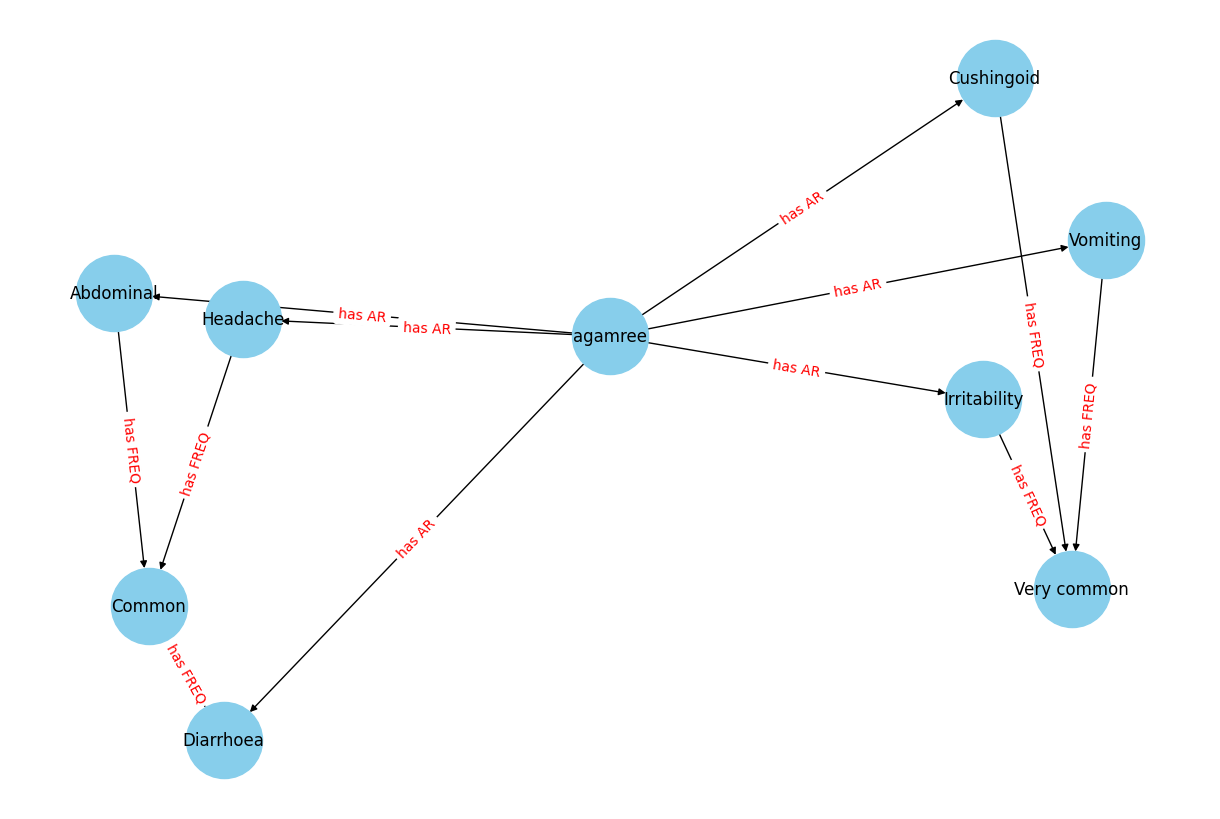

In [383]:
# Create a directed graph
G = nx.DiGraph()

drug = "agamree"

G.add_node(drug)

with open(os.path.join(PATH, "extracted_tables", drug + ".csv")) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')

    for row in csv_reader:
        adverse_reaction = row[0]
        frequency = row[1]

        print(f"Adverse Reaction: {adverse_reaction} Frequency: {frequency}")

        G.add_node(adverse_reaction)
        G.add_node(frequency)

        G.add_edge(drug, adverse_reaction, relationship="has AR")
        G.add_edge(adverse_reaction, frequency, relationship="has FREQ")

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=3000, edge_color='black', linewidths=1, font_size=12)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'relationship')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

# Show the graph
plt.show()

In [393]:
import rdflib
from rdflib import Graph, Literal, RDF, URIRef, Namespace
from rdflib.namespace import FOAF, XSD
import matplotlib.pyplot as plt
import networkx as nx

[a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'Memory']].
[a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'Memory']].
[a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'Memory']].
[a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'Memory']].
[a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'Memory']].
[a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'Memory']].
[a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'Memory']].


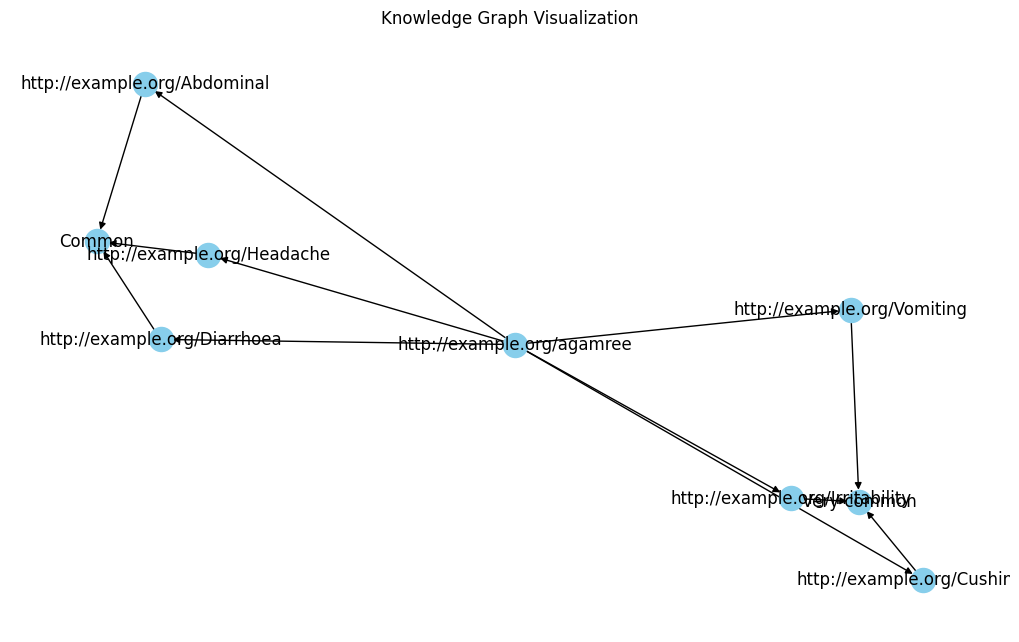

In [419]:
# Create a new graph
g = Graph()

# Define a namespace for our resources
namespace = "http://example.org/"

drug = "agamree"
drug_uri = URIRef(namespace + drug)


with open(os.path.join(PATH, "extracted_tables", drug + ".csv")) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')

    for row in csv_reader:
        reaction = row[0]
        frequency = row[1]

        reaction_uri = URIRef(namespace + reaction)
        frequency_literal = Literal(frequency, datatype=XSD.string)

        # Add triples to the graph
        g.add((drug_uri, FOAF.knows, reaction_uri))
        g.add((reaction_uri, FOAF.knows, frequency_literal))

        print(g.serialize(destination='output.txt', format='turtle'))

nx_graph = nx.DiGraph()
for s, p, o in g:
    nx_graph.add_edge(str(s), str(o))

# Draw the graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, arrows=True, node_color='skyblue', edge_color='black')
plt.title("Knowledge Graph Visualization")
plt.show()